# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 12            
model_seed = 2           

# --- Training configuration ---
epochs = 200            

# --- Dataset configuration ---
base_data_size = 60      
dataset_type = "data"   
dataset_quantities = [0, 600-60, 2000 - 60, 6000 - 60, 20000 - 60, 60000 - 60]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
import MNIST_CNN_model_data as model_module

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device=device
)

# CNN-specific initialization parameters
conv_channels = [32, 64]  # number of filters per conv layer
fc_dims = [128]           # fully connected layer sizes

# Grab model
model_template = model_module.get_model(
    conv_channels=conv_channels,
    fc_dims=fc_dims,
    device=device,
    seed=model_seed
)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = min(len(x_train), 1024)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=20,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/200: Train Loss 2.2930 | Test Loss 2.2897 | accs Train 0.1167 Test 0.0953


Epoch 20/200: Train Loss 0.0157 | Test Loss 1.0976 | accs Train 1.0000 Test 0.7129


Epoch 40/200: Train Loss 0.0002 | Test Loss 1.6219 | accs Train 1.0000 Test 0.7198


Epoch 60/200: Train Loss 0.0001 | Test Loss 1.7081 | accs Train 1.0000 Test 0.7239


Epoch 80/200: Train Loss 0.0001 | Test Loss 1.7291 | accs Train 1.0000 Test 0.7241


Epoch 100/200: Train Loss 0.0001 | Test Loss 1.7414 | accs Train 1.0000 Test 0.7229


Epoch 120/200: Train Loss 0.0001 | Test Loss 1.7447 | accs Train 1.0000 Test 0.7226


Epoch 140/200: Train Loss 0.0000 | Test Loss 1.7471 | accs Train 1.0000 Test 0.7229


Epoch 160/200: Train Loss 0.0000 | Test Loss 1.7491 | accs Train 1.0000 Test 0.7233


Epoch 180/200: Train Loss 0.0000 | Test Loss 1.7511 | accs Train 1.0000 Test 0.7238


Epoch 200/200: Train Loss 0.0000 | Test Loss 1.7532 | accs Train 1.0000 Test 0.7241
Completed training with 0 additional samples of data


Epoch 1/200: Train Loss 2.3088 | Test Loss 2.2401 | accs Train 0.0767 Test 0.1010


Epoch 20/200: Train Loss 0.2104 | Test Loss 0.4512 | accs Train 0.9317 Test 0.8726


Epoch 40/200: Train Loss 0.0266 | Test Loss 0.4084 | accs Train 1.0000 Test 0.9049


Epoch 60/200: Train Loss 0.0066 | Test Loss 0.4148 | accs Train 1.0000 Test 0.9125


Epoch 80/200: Train Loss 0.0032 | Test Loss 0.4293 | accs Train 1.0000 Test 0.9144


Epoch 100/200: Train Loss 0.0021 | Test Loss 0.4408 | accs Train 1.0000 Test 0.9157


Epoch 120/200: Train Loss 0.0015 | Test Loss 0.4495 | accs Train 1.0000 Test 0.9166


Epoch 140/200: Train Loss 0.0012 | Test Loss 0.4573 | accs Train 1.0000 Test 0.9171


Epoch 160/200: Train Loss 0.0009 | Test Loss 0.4640 | accs Train 1.0000 Test 0.9175


Epoch 180/200: Train Loss 0.0008 | Test Loss 0.4702 | accs Train 1.0000 Test 0.9176


Epoch 200/200: Train Loss 0.0006 | Test Loss 0.4759 | accs Train 1.0000 Test 0.9179
Completed training with 540 additional samples of data
Epoch 1/200: Train Loss 2.2539 | Test Loss 2.1034 | accs Train 0.1435 Test 0.2271


Epoch 20/200: Train Loss 0.1639 | Test Loss 0.2624 | accs Train 0.9545 Test 0.9247


Epoch 40/200: Train Loss 0.0382 | Test Loss 0.1742 | accs Train 0.9940 Test 0.9525


Epoch 60/200: Train Loss 0.0113 | Test Loss 0.1700 | accs Train 0.9995 Test 0.9565


Epoch 80/200: Train Loss 0.0046 | Test Loss 0.1752 | accs Train 1.0000 Test 0.9577


Epoch 100/200: Train Loss 0.0024 | Test Loss 0.1808 | accs Train 1.0000 Test 0.9592


Epoch 120/200: Train Loss 0.0015 | Test Loss 0.1848 | accs Train 1.0000 Test 0.9590


Epoch 140/200: Train Loss 0.0010 | Test Loss 0.1889 | accs Train 1.0000 Test 0.9591


Epoch 160/200: Train Loss 0.0007 | Test Loss 0.1925 | accs Train 1.0000 Test 0.9594


Epoch 180/200: Train Loss 0.0006 | Test Loss 0.1951 | accs Train 1.0000 Test 0.9601


Epoch 200/200: Train Loss 0.0005 | Test Loss 0.1980 | accs Train 1.0000 Test 0.9605
Completed training with 1940 additional samples of data
Epoch 1/200: Train Loss 1.9691 | Test Loss 1.3056 | accs Train 0.4220 Test 0.6891


Epoch 20/200: Train Loss 0.0455 | Test Loss 0.0866 | accs Train 0.9888 Test 0.9730


Epoch 40/200: Train Loss 0.0075 | Test Loss 0.0724 | accs Train 0.9997 Test 0.9786


Epoch 60/200: Train Loss 0.0022 | Test Loss 0.0786 | accs Train 1.0000 Test 0.9784


Epoch 80/200: Train Loss 0.0009 | Test Loss 0.0833 | accs Train 1.0000 Test 0.9798


Epoch 100/200: Train Loss 0.0005 | Test Loss 0.0869 | accs Train 1.0000 Test 0.9799


Epoch 120/200: Train Loss 0.0003 | Test Loss 0.0900 | accs Train 1.0000 Test 0.9799


Epoch 140/200: Train Loss 0.0002 | Test Loss 0.0926 | accs Train 1.0000 Test 0.9797


Epoch 160/200: Train Loss 0.0002 | Test Loss 0.0945 | accs Train 1.0000 Test 0.9799


Epoch 180/200: Train Loss 0.0001 | Test Loss 0.0966 | accs Train 1.0000 Test 0.9799


Epoch 200/200: Train Loss 0.0001 | Test Loss 0.0984 | accs Train 1.0000 Test 0.9798
Completed training with 5940 additional samples of data


Epoch 1/200: Train Loss 1.0968 | Test Loss 0.3888 | accs Train 0.6851 Test 0.8794


Epoch 20/200: Train Loss 0.0187 | Test Loss 0.0412 | accs Train 0.9947 Test 0.9869


Epoch 40/200: Train Loss 0.0018 | Test Loss 0.0468 | accs Train 1.0000 Test 0.9878


Epoch 60/200: Train Loss 0.0005 | Test Loss 0.0518 | accs Train 1.0000 Test 0.9872


Epoch 80/200: Train Loss 0.0002 | Test Loss 0.0564 | accs Train 1.0000 Test 0.9877


Epoch 100/200: Train Loss 0.0001 | Test Loss 0.0600 | accs Train 1.0000 Test 0.9880


Epoch 120/200: Train Loss 0.0001 | Test Loss 0.0618 | accs Train 1.0000 Test 0.9878


Epoch 140/200: Train Loss 0.0001 | Test Loss 0.0640 | accs Train 1.0000 Test 0.9881


Epoch 160/200: Train Loss 0.0000 | Test Loss 0.0658 | accs Train 1.0000 Test 0.9876


Epoch 180/200: Train Loss 0.0000 | Test Loss 0.0679 | accs Train 1.0000 Test 0.9878


Epoch 200/200: Train Loss 0.0000 | Test Loss 0.0693 | accs Train 1.0000 Test 0.9879
Completed training with 19940 additional samples of data


Epoch 1/200: Train Loss 0.5366 | Test Loss 0.1589 | accs Train 0.8508 Test 0.9545


Epoch 20/200: Train Loss 0.0068 | Test Loss 0.0346 | accs Train 0.9981 Test 0.9904


Epoch 40/200: Train Loss 0.0003 | Test Loss 0.0383 | accs Train 1.0000 Test 0.9912


Epoch 60/200: Train Loss 0.0001 | Test Loss 0.0436 | accs Train 1.0000 Test 0.9914


Epoch 80/200: Train Loss 0.0000 | Test Loss 0.0473 | accs Train 1.0000 Test 0.9915


Epoch 100/200: Train Loss 0.0000 | Test Loss 0.0503 | accs Train 1.0000 Test 0.9916


Epoch 120/200: Train Loss 0.0000 | Test Loss 0.0533 | accs Train 1.0000 Test 0.9915


Epoch 140/200: Train Loss 0.0000 | Test Loss 0.0567 | accs Train 1.0000 Test 0.9914


Epoch 160/200: Train Loss 0.0000 | Test Loss 0.0598 | accs Train 1.0000 Test 0.9913


Epoch 180/200: Train Loss 0.0000 | Test Loss 0.0631 | accs Train 1.0000 Test 0.9914


Epoch 200/200: Train Loss 0.0000 | Test Loss 0.0659 | accs Train 1.0000 Test 0.9912
Completed training with 59940 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 1.7532 | accs: 0.7241
 540 samples | Test Loss: 0.4759 | accs: 0.9179
1940 samples | Test Loss: 0.1980 | accs: 0.9605
5940 samples | Test Loss: 0.0984 | accs: 0.9798
19940 samples | Test Loss: 0.0693 | accs: 0.9879


59940 samples | Test Loss: 0.0659 | accs: 0.9912

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model  540 | Train Loss: 0.0008 | accs: 1.0000
 Model 1940 | Train Loss: 0.0006 | accs: 1.0000
 Model 5940 | Train Loss: 0.0001 | accs: 1.0000
 Model 19940 | Train Loss: 0.0000 | accs: 1.0000
 Model 59940 | Train Loss: 0.0000 | accs: 1.0000

Dataset type: data, additional samples: 540
 Model    0 | Train Loss: 1.5824 | accs: 0.7467
 Model  540 | Train Loss: 0.0006 | accs: 1.0000
 Model 1940 | Train Loss: 0.0004 | accs: 1.0000
 Model 5940 | Train Loss: 0.0001 | accs: 1.0000
 Model 19940 | Train Loss: 0.0000 | accs: 1.0000
 Model 59940 | Train Loss: 0.0000 | accs: 1.0000

Dataset type: data, additional samples: 1940
 Model    0 | Train Loss: 1.7668 | accs: 0.7270
 Model  540 | Train Loss: 0.3651 | accs: 0.9410
 Model 1940 | Train Loss: 0.0004 | accs: 1.0000
 Model 5940 | Train Loss: 0.0001 | accs: 1.0000
 

 Model    0 | Train Loss: 1.8075 | accs: 0.7190
 Model  540 | Train Loss: 0.5108 | accs: 0.9142
 Model 1940 | Train Loss: 0.2108 | accs: 0.9605
 Model 5940 | Train Loss: 0.0962 | accs: 0.9830


 Model 19940 | Train Loss: 0.0000 | accs: 1.0000
 Model 59940 | Train Loss: 0.0000 | accs: 1.0000

Dataset type: data, additional samples: 59940


 Model    0 | Train Loss: 1.8484 | accs: 0.7139
 Model  540 | Train Loss: 0.5108 | accs: 0.9123


 Model 1940 | Train Loss: 0.2180 | accs: 0.9578
 Model 5940 | Train Loss: 0.1144 | accs: 0.9787


 Model 19940 | Train Loss: 0.0603 | accs: 0.9905
 Model 59940 | Train Loss: 0.0000 | accs: 1.0000


### Model + Data Specific Verification

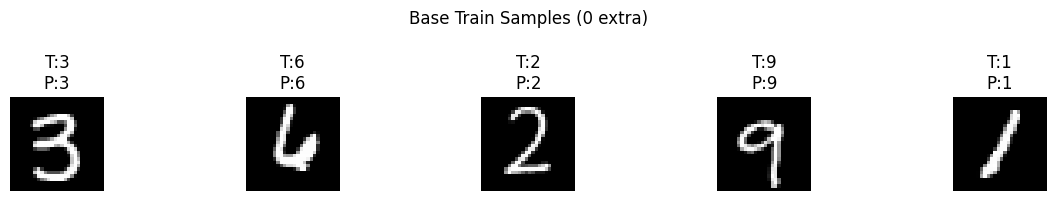

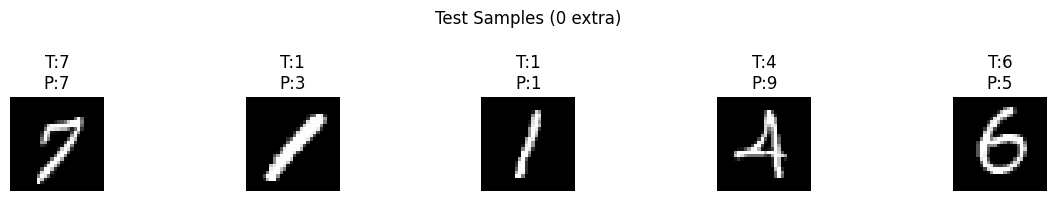

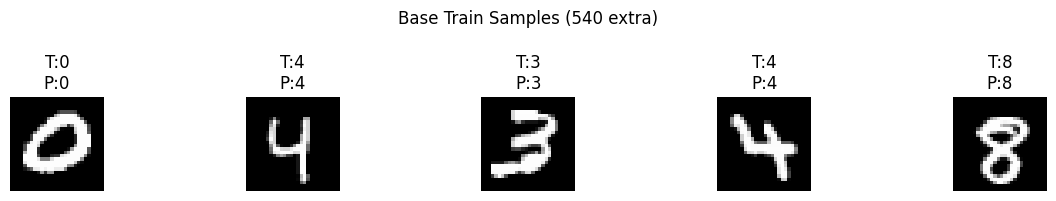

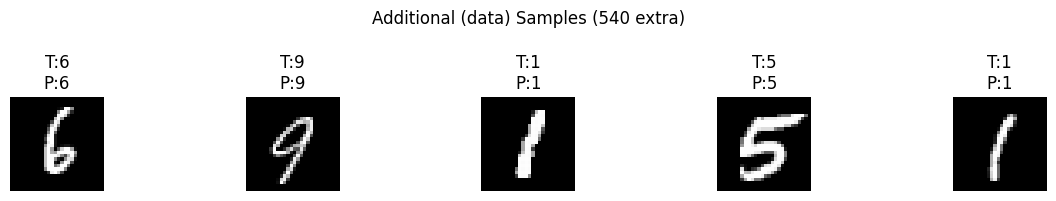

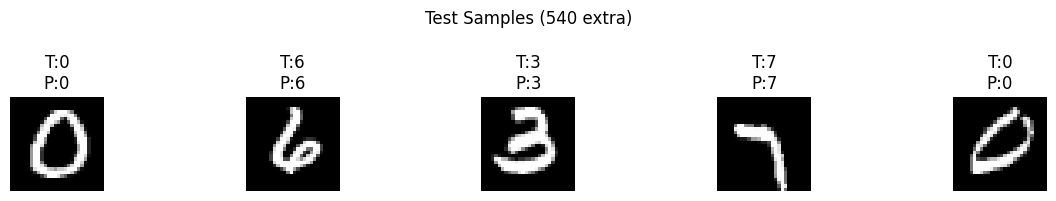

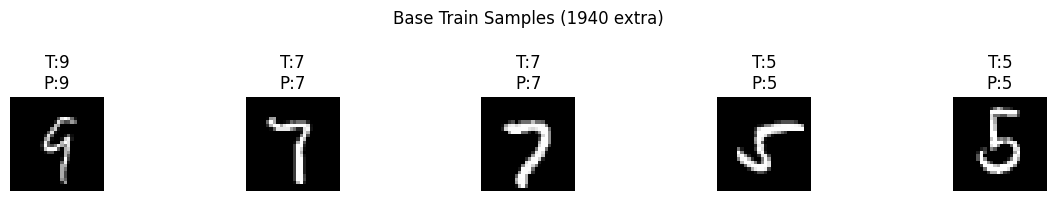

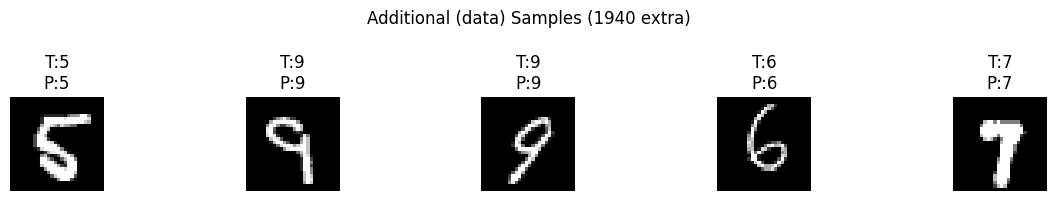

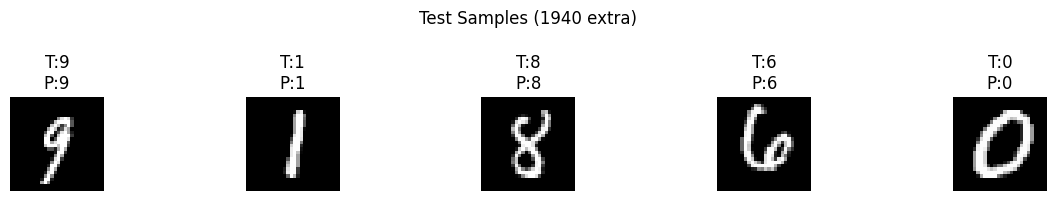

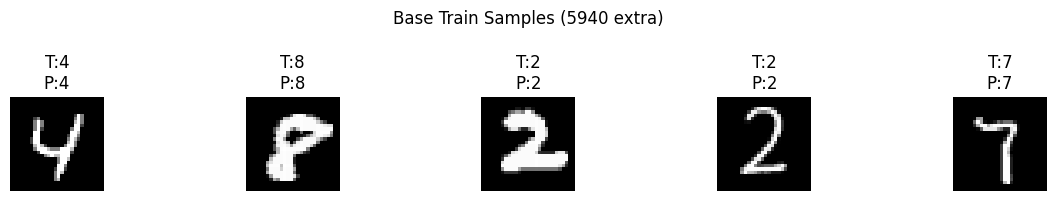

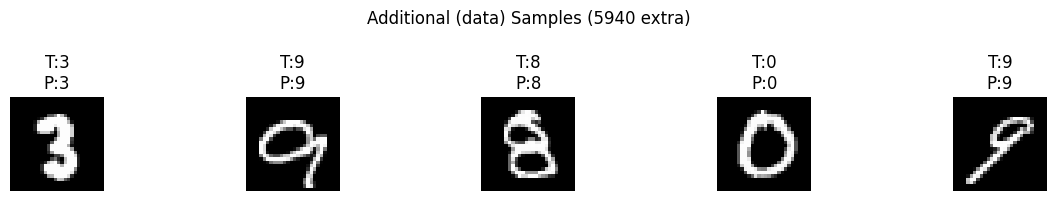

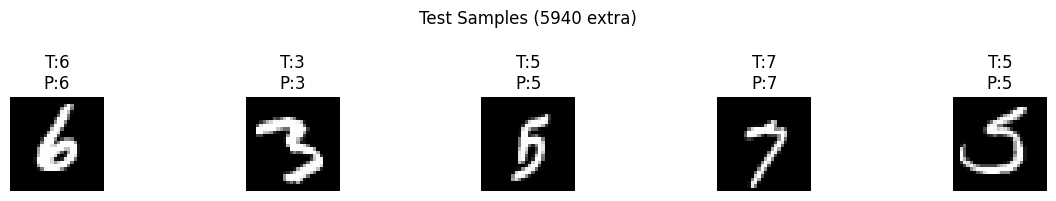

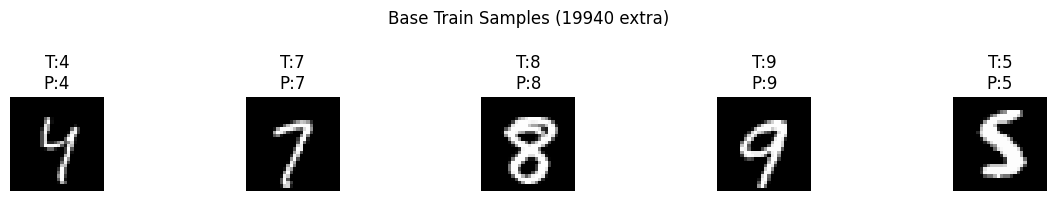

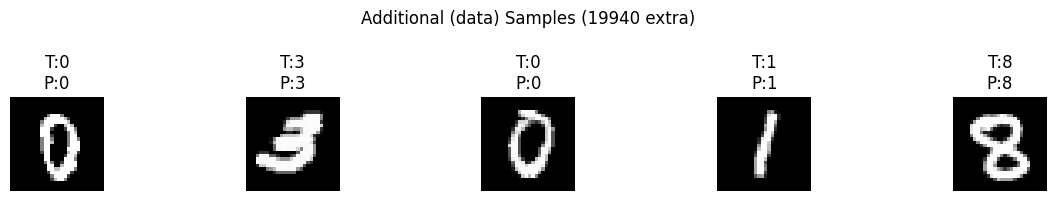

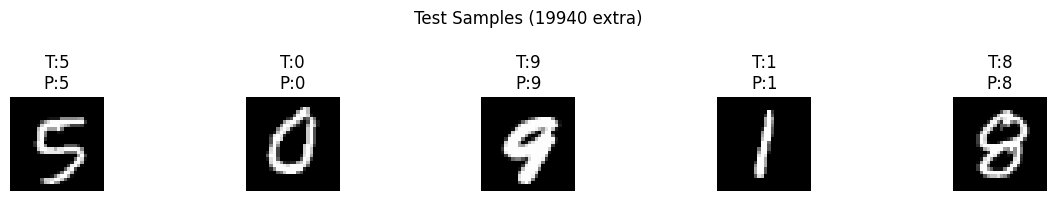

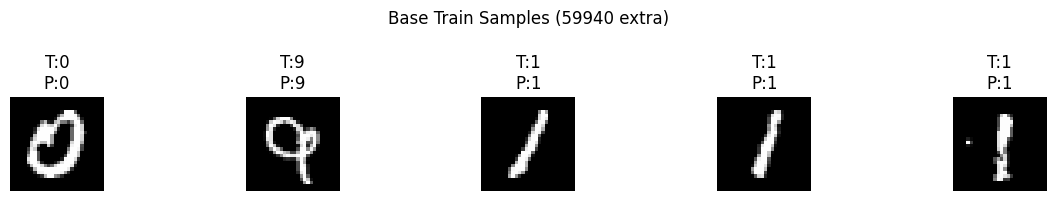

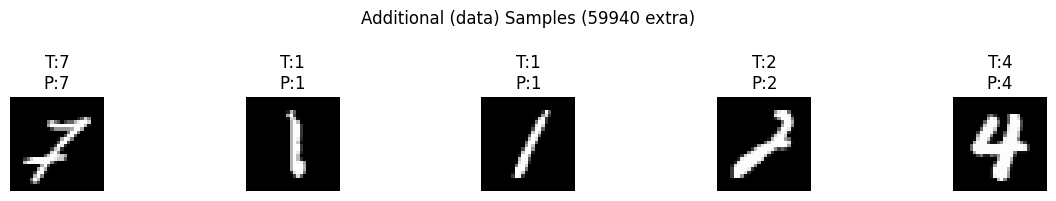

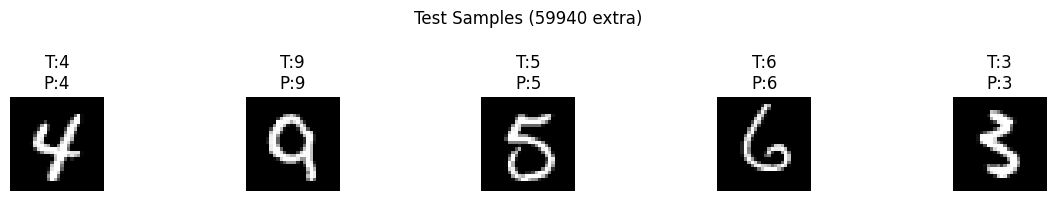

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_540.pt
Saved model: models_and_data/model_additional_540.pt
✅ Model saved to models_and_data\model_additional_1940.pt
Saved model: models_and_data/model_additional_1940.pt
✅ Model saved to models_and_data\model_additional_5940.pt
Saved model: models_and_data/model_additional_5940.pt
✅ Model saved to models_and_data\model_additional_19940.pt
Saved model: models_and_data/model_additional_19940.pt
✅ Model saved to models_and_data\model_additional_59940.pt
Saved model: models_and_data/model_additional_59940.pt
